# Dollar Bar/ Imbalance bar

In view of absence of open-source quant library and other resources. This notebook will cover specifically only how to restructure your HFT data into dollar bar data sample.

Using such data structure could generate good market signal for different plausible quant strategies.

In order to appreciate this technique, I highly recommend you to read the below research.

[Volume Clock SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2034858)

[Free HFT data generator](https://gist.github.com/boyboi86/5e00faf48f60abfdbe838fbdee269471)

Please remember to save this as your sample data to csv format, otherwise, your result may not be consistant. (This sample data can get you started for 1st 5 chapters)

It is not easy to be motivated because everything within the AFML textbook are considered advance techniques which combines Statistics/ Finance/ Behavioral Economics. Moreover, all the codes I used were written mostly from scratch (proprietary) plus the idea of maintaining a open-source quant library is daunting especially when I am doing everything alone.

I hope by sharing some snippet of codes would provide some assistance to appreciate the mathematical motivation behind what Dr Marcos' work, but more importantly assist in your learning progress.

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import research as rs

%matplotlib inline

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.0.4


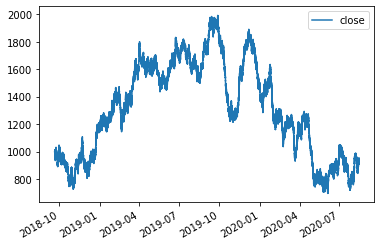

In [2]:
data = rs.create_price_data()

**Note**

The above data was generated based on the function I created.

The gist link is provided above.

Different types of generators are used for different cases studies/ research so make sure you choose the right one.

**Note**

Remember to save the generated data to csv format so that your answers can be consistent.

At the same time, you can run the function multiple times to get a time-series price that are closer to S&P futures price.

It's possible. I tried before.

In [3]:
data # 2 years worth of data on per min basis

,close
2018-09-20 04:30:15.514334,1000.000000
2018-09-20 04:31:15.514334,998.543690
2018-09-20 04:32:15.514334,997.530318
2018-09-20 04:33:15.514334,998.541121
2018-09-20 04:34:15.514334,999.698486
...,...
2020-08-14 15:05:15.514334,934.038261
2020-08-14 15:06:15.514334,933.225359
2020-08-14 15:07:15.514334,930.604014
2020-08-14 15:08:15.514334,931.115651


**Note**

For the purpose of demostration and simplicity, we will assume the "close" price is actually total dollar-volume transacted.

This is an important assumption!

**Note**

The whole idea is that whenever the transacted volume deviates from normal/ expected 10% of daily transacted dollar-volume (Refer to research paper provided). This resampled data will quickly capture such abnormality.

If transaction dollar-volume exceeds expectation (abnormal market behavior), it would reflect in the investors/ traders pouring/ unloading a particular asset hence driving up the prices and vice versa.

**Note**

Try to understand the code snippet then try to read the mathematical equation again. It would make more sense.

In [4]:
def dd_bars(data: pd.DataFrame, m: int = None):
    '''
    params: data => dataframe of close series
    params: column => column of data sample; vol, dollar etc
    '''    
    ts, idx = 0, []
    for i, x in enumerate(data):
        ts += x
        if ts >= m:
            ts = 0; idx.append(i)
            continue
    return data.iloc[idx]

**Note**

The below is the outcome after we resample the data.


In [5]:
tb = dd_bars(data = data.close, m = 1000000) # assuming 10% of daily transacted volme is 1,000,000
tb

2018-09-20 21:12:15.514334     979.797689
2018-09-21 14:29:15.514334     941.202564
2018-09-22 07:59:15.514334     958.991442
2018-09-23 00:57:15.514334     987.582134
2018-09-23 17:28:15.514334    1021.631874
                                 ...     
2020-08-11 06:09:15.514334     854.092356
2020-08-12 01:28:15.514334     861.996249
2020-08-12 20:38:15.514334     888.859414
2020-08-13 14:58:15.514334     914.903432
2020-08-14 08:58:15.514334     947.081958
Name: close, Length: 1309, dtype: float64

**Note**

If your realized by now, total data points generated was different after we resample them.

Based on per minute basis, if any abnormal market price bahvior was detected, it would have produce a "buy"/ "sell" signal depending on the type of investment factor (long/short).

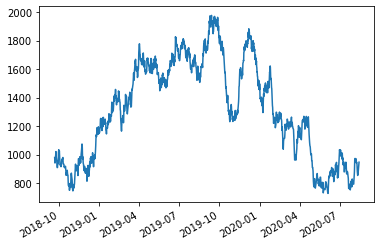

In [6]:
tb.plot()

**Note**

The code snippet is just to assist you to appreciate the mathematical motivation for this technique. 

However, more could be done to improve this algorithm. Feel free to customize them.

**Note**

This algorithm although widely used in index futures/ commodities derivatives is applicable to crypto assets.

In fact, I believe it is well-adapted to crypto-assets since it factors in alot of behaviorial economics element.

In [7]:
def returns(data, tickers):
    b_t = []
    _ = data[tickers].pct_change()
    _.dropna(inplace=True)
    for i, value in enumerate(_):
        b_t.append(value)
    return b_t

def ema_tick(imbalance, weighted_count, weighted_sum, weighted_sum_T, limit, alpha, T_count):
    weighted_sum_T = limit + (1 - alpha) * weighted_sum_T
    weighted_sum = limit / (1.0 * T_count) + (1 - alpha) * weighted_sum
    weighted_count = 1 + (1 - alpha) * weighted_count
    imbalance = weighted_sum_T * weighted_sum/ weighted_count ** 2
    return imbalance, weighted_count, weighted_sum, weighted_sum_T

def imbalance_bar(data, tickers, set_limit, alpha):
    b_t = returns(data, tickers)
    bt_arr = []
    imb_arr = []
    weighted_sum_T = 0
    weighted_sum = 0
    weighted_count = 0
    bt_count = 0
    bt_up = 0
    b_imb_sum = 0
    b_sum = 0
    imbalance = 0
    for i, value in enumerate(b_t):
        bt_count += 1
        if value >= 0:
            b_sum += b_t[i]
            b_imb_sum += 1
            bt_up += 1
            bt_arr.append(b_sum)
        else:
            b_imb_sum -= 1
            b_sum += b_t[i]
            bt_arr.append(b_sum)
            
        upper_limit = max(b_imb_sum, bt_up)
        if upper_limit >= set_limit:
            imbalance, weighted_count, weighted_sum, weighted_sum_T = ema_tick(imbalance, 
                                                                               weighted_count,
                                                                               weighted_sum,
                                                                               weighted_sum_T,
                                                                               upper_limit,
                                                                               alpha,
                                                                               bt_count)
            imb_arr.append(imbalance) # exclude ewma without hitting threshold
            if upper_limit == bt_up:
                bt_up = 0
            else:
                b_imb_sum = 0
        else:
            imb_arr.append(0.0)    
    return bt_arr, imb_arr, b_t

**Note**

The above is for imbalance bar sampling.

As you can see it includes both buy and sell transactions dollar-volume. Instead of a single-direction like dollar bar sample as demostrated above.

**Note**

This is important especially for liquidity check/ impact analysis, since algorithms does not factor in liquidity drying up. If a strong imbalance is noticed, bid-ask spread will start to increase.

This will impact profitability of transactions especially for HFT.

**Note**

If a quant trader were using VWAP as a indicator for signal effect. He or she might require to understand the above algorithm, to avoid thinning profit margins.